<center>
</br>
<p><font size="5"> M2MO - 2025</span></p>
<p><font size="4">  UE PDE & Numerical Methods </font></p>
<p></p>
<p><font size="5">  Project - Mean Field Games with Congestion Effects </font></p>

**<p><font size="5"> Nathan Sanglier, Ronan Pécheul </font></p>**
</p></br>
</p>
</center>

---------------------------

## <span style="color:#00B8DE">0 - Imports & Utils </span>

In [41]:
import  time
import  numpy                   as      np
import  pandas                  as      pd
import  seaborn                 as      sns
import  matplotlib.pyplot       as      plt
import  matplotlib.animation    as      animation
from    matplotlib.ticker       import  PercentFormatter
from    IPython.display         import  HTML
from    pathlib                 import  Path
from    math                    import  sqrt, pi
from    tqdm                    import  tqdm
from    scipy.sparse.linalg     import  spsolve
from    scipy.sparse            import  csr_matrix

In [42]:
def contour_plot(MF_res, T, Nt, Nh):
    '''
    Returns a contour plot of the solutions u and m of the discrete mean-field problem.
    '''
    h, dt       = 1/(Nh-1), T/Nt
    x, t        = np.arange(0, Nh)*h, np.arange(0, Nt+1)*dt
    fig, axs    = plt.subplots(1, 2, figsize=(14, 4))
    cont1       = axs[0].contour(x, t, MF_res[:, :Nh], levels=50, cmap="viridis")
    cont2       = axs[1].contour(x, t, MF_res[:, Nh:], levels=50, cmap="viridis")
    axs[0].grid()
    axs[1].grid()
    plt.colorbar(cont1)
    plt.colorbar(cont2)
    axs[0].set_xlabel("x")
    axs[1].set_xlabel("x")
    axs[0].set_ylabel("t")
    axs[0].set_title("contour lines of u")
    axs[1].set_title("contour lines of m")
    return fig

In [43]:
def evolution_video(MF_res, T, Nt, Nh):
    '''
    Returns a video of the evolution of the solutions u and m of the discrete mean-field problem.
    '''
    plt.close('all')
    h, dt   = 1/(Nh-1), T/Nt
    x       = np.arange(0, Nh)*h
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    u       = ax.plot(x, MF_res[0, :Nh], label='u')[0]
    m       = ax.plot(x, MF_res[0, Nh:], label='m')[0]
    ax.set_title(f"t = {0*dt:.2f}")
    ax.grid()
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("value")
    
    def update(n):
        u.set_ydata(MF_res[n, :Nh])
        m.set_ydata(MF_res[n, Nh:])
        ax.set_title(f"t = {n*dt:.2f}")
        return u, m
    
    video = animation.FuncAnimation(fig, update, frames=Nt+1, blit=True, interval=100, repeat=False)
    plt.close(fig)
    return video

In [44]:
def save_stats_to_txt(dict, filename):
    with open(filename, "w") as file:
        for key, value in dict.items():
            file.write(f"{key}\n")
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, list) or isinstance(item, np.ndarray):
                        file.write(", ".join(map(str, item)) + "\n")
                    else:
                        file.write(", ".join(map(str, value)) + "\n")
                        break
            else:
                file.write(str(value) + "\n")
    return None

In [45]:
def load_stats_from_txt(filename):
    result      = {}
    current_key = None

    with open(filename, "r") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if not line[0].isdigit():
                current_key         = line
                result[current_key] = []
            else:
                values = list(map(float, line.split(", ")))
                if current_key in ["fixpoint_increments", "runtime"]:
                    if current_key == "runtime":
                        result[current_key] = values[0]
                    else:
                        result[current_key] = values
                else:
                    result[current_key].append(values)

    return result

## <span style="color:#00B8DE">I - Mean Field Problem Resolution </span>

In [46]:
def m0(x):
    return sqrt(300/pi) * np.exp(-300*(x-0.2)**2)

def m0_bar(x):
    return m0(x)

def phi(x):
    return -np.exp(-40*(x-0.7)**2)

def g(x):
    return 0

In [47]:
def pos(x):
    return np.maximum(x, 0)
def neg(x):
    return -np.minimum(x, 0)


def Htilde(p1, p2, mu, beta, c0, c1, alpha):
    '''
    Returns the discrete Hamiltonian of the mean-field problem.
    '''
    return 1/beta * (neg(p1)**2 + pos(p2)**2)**(beta/2) / (c0 + c1*mu)**alpha

def Htilde_p1(p1, p2, mu, beta, c0, c1, alpha):
    '''
    Returns the derivative wrt p1 of the discrete Hamiltonian of the mean-field problem.
    '''
    return -neg(p1) * (neg(p1)**2 + pos(p2)**2)**(beta/2 - 1) / (c0 + c1*mu)**alpha

def Htilde_p2(p1, p2, mu, beta, c0, c1, alpha):
    '''
    Returns the derivative wrt p2 of the discrete Hamiltonian of the mean-field problem.
    '''
    return pos(p2) * (neg(p1)**2 + pos(p2)**2)**(beta/2 - 1) / (c0 + c1*mu)**alpha

def Gtilde(p1, p2, mu, beta, c0, c1, alpha):
    '''
    Returns the additionnal term in the HJB equation in case of a mean-field control.
    '''
    return -c1*alpha*mu/(c0 + c1*mu) * Htilde(p1, p2, mu, beta, c0, c1, alpha)

In [48]:
def discrete_transport_mat(W, M, Nh, h, beta, c0, c1, alpha):
    '''
    Returns the matrix of the discrete transport (linear) operator M -> T(U^n, M, Tilde M).
    '''
    res     = np.zeros((Nh, Nh))
    gamma   = Htilde_p1((W[2:] - W[1:-1])/h, (W[1:-1] - W[:-2])/h, M, beta, c0, c1, alpha)/h
    epsilon = Htilde_p2((W[2:] - W[1:-1])/h, (W[1:-1] - W[:-2])/h, M, beta, c0, c1, alpha)/h
    np.fill_diagonal(res, gamma - epsilon)
    np.fill_diagonal(res[1:, :], -gamma[:-1])
    np.fill_diagonal(res[:, 1:], epsilon[1:])
    return res

def D2M_mat(Nh, h, v):
    res = np.zeros((Nh, Nh))
    np.fill_diagonal(res, 2*v/h**2)
    np.fill_diagonal(res[1:, :], -v/h**2)
    np.fill_diagonal(res[:, 1:], -v/h**2)
    return res

In [49]:
def newton(U, M, dt, h, v, x, beta, c0, c1, alpha, f0tilde, f0tilde_prime, crit_newt, SPARSE, MF_TYPE):
    '''
    Newton method to solve HJB at timestep $n$.
    Returns hat U^{n, (k+1)} given hat U{n+1, (k+1)} and M^{n+1, (k)}. 
    '''
    start = time.time()
    Nh = len(x)
    def F(W):
        Dt      = (U - W[1:-1])/dt
        D1      = (W[2:] - W[1:-1])/h
        D2      = (W[1:-1] - W[:-2])/h
        Laplace = -(2*W[1:-1] - W[2:] - W[:-2])/h**2
        res     = -Dt - v*Laplace + Htilde(D1, D2, M, beta, c0, c1, alpha) - g(x) - f0tilde(M)
        if MF_TYPE == 'CONTROL':
            res += Gtilde(D1, D2, M, beta, c0, c1, alpha) - M*f0tilde_prime(M)
        return res
    
    def J(W):
        # Jacobian of F; notice that the Jacobian matrix of $\Tilde H$ is the matrix of the discrete transport operator
        disc_transp = discrete_transport_mat(W, M, Nh, h, beta, c0, c1, alpha)
        res         = np.eye(Nh)/dt +  D2M_mat(Nh, h, v) - disc_transp.T
        if MF_TYPE == 'CONTROL':
            res += c1*alpha*M/(c0 + c1*M) * disc_transp.T
        return res
    
    V, Vold = U.copy(), np.repeat(np.inf, len(U))
    k       = 0
    incr    = []
    while (np.linalg.norm(V-Vold)>crit_newt):
        Vold    = V.copy()
        W       = np.concatenate(([U[0]], V, [U[-1]]))
        delta_V = spsolve(csr_matrix(J(W)), F(W)) if SPARSE else np.linalg.solve(J(W), F(W))
        V      -= delta_V
        k      += 1
        incr.append(np.linalg.norm(delta_V))
        if k >= 30:
            print(f'Warning : There may be CV issue in Newton method - nb of current iterations = {k}.')
    if k == 1:
        print('Warning : Newton method converged in 1 iteration.')
    end = time.time()
    return V, incr, end-start, k

In [50]:
def HJB_solver(M, dt, h, v, x, beta, c0, c1, alpha, f0tilde, f0tilde_prime, crit_newt, SPARSE, PRINT, MF_TYPE):
    '''
    Solves HJB with backward iteration.
    '''
    U           = np.zeros_like(M)
    U[-1, :]    = phi(x)
    Nt          = U.shape[0]-1
    newt_incrs  = []
    newt_times  = np.zeros(Nt)
    newt_niters = np.zeros(Nt)
    for n in tqdm(range(Nt-1, -1, -1), desc="Processing HJB solver", disable=not PRINT):
        U[n, :], incr, runtime, k   = newton(U[n+1, :], M[n+1, :], dt, h, v, x, beta, c0, c1, alpha, f0tilde, f0tilde_prime, crit_newt, SPARSE, MF_TYPE)
        newt_times[n]               = runtime
        newt_niters[n]              = k
        newt_incrs.extend(incr)

    return U, newt_incrs, newt_times, newt_niters

def KFP_solver(U, M, dt, h, v, x, beta, c0, c1, alpha, SPARSE, PRINT):
    '''
    Solves KFP with forward iteration.
    '''
    M_new       = np.zeros_like(M)
    M_new[0, :] = m0_bar(x)
    Nh          = len(x)
    Nt          = U.shape[0]-1
    sys_times   = np.zeros(Nt)

    def system_mat(W, M):
        # Matrix of the implicit scheme
        return np.eye(Nh) + dt * (D2M_mat(Nh, h, v) - discrete_transport_mat(W, M, Nh, h, beta, c0, c1, alpha))

    for n in tqdm(range(Nt), desc="Processing KFP solver", disable=not PRINT):
        W               = np.concatenate(([U[n, 0]], U[n, :], [U[n, -1]]))
        start           = time.time()
        M_new[n+1, :]   = spsolve(csr_matrix(system_mat(W, M[n+1, :])), M_new[n, :]) if SPARSE else np.linalg.solve(system_mat(W, M[n+1, :]), M_new[n, :])
        end             = time.time()
        sys_times[n]    = end-start
        # Due to numerical approximations, the density can be negative but very close to zero. We set it to zero in that case.
        M_new[n+1, :][M_new[n+1, :]<0 & (M_new[n, :]>-10**(-10))] = 0
        if np.sum(M_new[n+1, :]) - np.sum(M_new[n, :]) >= 10**(-10):
            # The mass should be conserved
            print(f'Warning : sum_i M_i^(n+1) = {np.sum(M_new[n+1, :])} != {np.sum(M_new[n, :])}')
        if np.any(M_new[n+1, :]<0):
            print(f'Error : Negative density detected at {np.sum(M_new[n+1, :]<0)} points.')
            print(M_new[n+1, :][M_new[n+1, :]<0])
            raise ValueError('Negative density detected.')
    return M_new, sys_times

In [51]:
def MF_solver(sigma, beta, c0, c1, alpha, T, Nt, Nh, theta, f0tilde, f0tilde_prime, crit_fixpoint, crit_newt, SPARSE, PRINT_SOLVER, PRINT_INC, MF_TYPE, max_iters=1000):
    '''
    Solves the mean-field game or control problem with a fixed-point algorithm.
    '''
    start = time.time()
    if MF_TYPE == 'CONTROL' and f0tilde_prime is None:
        raise ValueError('f0tilde_prime must be provided for MF_TYPE = CONTROL.')
    if MF_TYPE != 'CONTROL' and MF_TYPE != 'GAME':
        raise ValueError('MF_TYPE must be either CONTROL or GAME.')
    v, h, dt        = sigma**2/2, 1/(Nh-1), T/Nt
    x               = np.arange(0, Nh)*h
    M               = np.tile(m0_bar(x), (Nt+1, 1))
    U               = np.tile(phi(x), (Nt+1, 1))
    X               = np.column_stack((U, M))
    X_old           = np.full_like(X, np.inf)   
    k               = 0
    stats           = {'newton_increments': [], 'newton_times': [], 'newton_niters': [], 'system_times': [], 'fixpoint_increments': []}  
    while np.linalg.norm(X-X_old)/sqrt(X.size) > crit_fixpoint and k < max_iters:
        X_old                                           = X.copy() 
        X[:, :Nh], newt_incrs, newt_times, newt_niters  = HJB_solver(X[:, Nh:], dt, h, v, x, beta, c0, c1, alpha, f0tilde, f0tilde_prime, crit_newt, SPARSE, PRINT_SOLVER, MF_TYPE)
        X[:, Nh:], sys_times                            = KFP_solver(X[:, :Nh], X[:, Nh:], dt, h, v, x, beta, c0, c1, alpha, SPARSE, PRINT_SOLVER)
        X                                               = theta*X + (1-theta)*X_old
        k                                               += 1
        norm_incr                                       = np.linalg.norm(X-X_old)/sqrt(X.size)
        if (k <= 5 or k%10 == 0) and PRINT_INC:
            print(f"MFG solver, iteration {k}, increment = {(norm_incr):.2e}")
        if k == max_iters:
            print(f"Warning : MFG solver did not converge after {max_iters} iterations.")
        stats['newton_increments'].append(newt_incrs)
        stats['newton_times'].append(newt_times)
        stats['newton_niters'].append(newt_niters)
        stats['system_times'].append(sys_times)
        stats['fixpoint_increments'].append(norm_incr)
    if k == 1:
        print('Warning : MFG solver converged in 1 iteration.')
    end = time.time()
    stats['runtime'] = end-start

    return X, stats

## <span style="color:#00B8DE">II - Mean Field Game Results </span>

In [52]:
f0tilde1    = lambda m: m/10
f0tilde2    = lambda m: 0
f0tilde2_p  = lambda m: 0

sets_params = {
    'beta'      : {'A': 2,          'B': 2,         'C': 2,         'D': 2,         'E': 2,         'F': 2,         'G': 2          },
    'c0'        : {'A': 0.1,        'B': 0.1,       'C': 0.01,      'D': 0.01,      'E': 1,         'F': 0.1,       'G': 0.1        },
    'c1'        : {'A': 1,          'B': 5,         'C': 2,         'D': 2,         'E': 3,         'F': 1,         'G': 1          },    
    'alpha'     : {'A': 0.5,        'B': 1,         'C': 1.2,       'D': 1.5,       'E': 2,         'F': 0.5,       'G': 0.5        },
    'sigma'     : {'A': 0.02,       'B': 0.02,      'C': 0.1,       'D': 0.2,       'E': 0.002,     'F': 0.02,      'G': 0.02       },
    'f0tilde'   : {'A': f0tilde1,   'B': f0tilde1,  'C': f0tilde1,  'D': f0tilde1,  'E': f0tilde1,  'F': f0tilde2,  'G': f0tilde2   },
    'f0tilde_p' : {'A': None,       'B': None,      'C': None,      'D': None,      'E': None,      'F': None,      'G': f0tilde2_p },
    'type'      : {'A': 'GAME',     'B': 'GAME',    'C': 'GAME',    'D': 'GAME',    'E': 'GAME',    'F': 'GAME',    'G': 'CONTROL'  }
}
theta                           = 0.02    
crit_newt, crit_fixpoint        = 10**(-12), 2*10**(-5)
T, Nt, Nh                       = 1, 100, 201
SPARSE, PRINT_SOLVER, PRINT_INC = True, False, False

In [53]:
'''
Path("results").mkdir(parents=True, exist_ok=True)
Path("statistics").mkdir(parents=True, exist_ok=True)
sets = ['A', 'B', 'C', 'D', 'E', 'F']
for s in sets:
    print(f"Processing set {s}...")
    MF_res, MF_stats    = MF_solver(sets_params['sigma'][s], sets_params['beta'][s], sets_params['c0'][s], sets_params['c1'][s], sets_params['alpha'][s], T, Nt, Nh, theta, sets_params['f0tilde'][s], sets_params['f0tilde_p'][s], crit_fixpoint, crit_newt, SPARSE, PRINT_SOLVER, PRINT_INC, sets_params['type'][s])
    video               = evolution_video(MF_res, T, Nt, Nh)
    fig                 = contour_plot(MF_res, T, Nt, Nh)
    np.savetxt(f"results/MF_res_{s}.csv", MF_res, delimiter=",")
    video.save(f"results/MF_res_{s}.mp4")
    plt.savefig(f'results/MF_res_{s}.png', bbox_inches='tight', dpi=300)
    save_stats_to_txt(MF_stats, f"statistics/MF_stats_{s}.txt")
    print(f"Set {s} processed.")
plt.close('all')
'''

'\nPath("results").mkdir(parents=True, exist_ok=True)\nPath("statistics").mkdir(parents=True, exist_ok=True)\nsets = [\'A\', \'B\', \'C\', \'D\', \'E\', \'F\']\nfor s in sets:\n    print(f"Processing set {s}...")\n    MF_res, MF_stats    = MF_solver(sets_params[\'sigma\'][s], sets_params[\'beta\'][s], sets_params[\'c0\'][s], sets_params[\'c1\'][s], sets_params[\'alpha\'][s], T, Nt, Nh, theta, sets_params[\'f0tilde\'][s], sets_params[\'f0tilde_p\'][s], crit_fixpoint, crit_newt, SPARSE, PRINT_SOLVER, PRINT_INC, sets_params[\'type\'][s])\n    video               = evolution_video(MF_res, T, Nt, Nh)\n    fig                 = contour_plot(MF_res, T, Nt, Nh)\n    np.savetxt(f"results/MF_res_{s}.csv", MF_res, delimiter=",")\n    video.save(f"results/MF_res_{s}.mp4")\n    plt.savefig(f\'results/MF_res_{s}.png\', bbox_inches=\'tight\', dpi=300)\n    save_stats_to_txt(MF_stats, f"statistics/MF_stats_{s}.txt")\n    print(f"Set {s} processed.")\nplt.close(\'all\')\n'

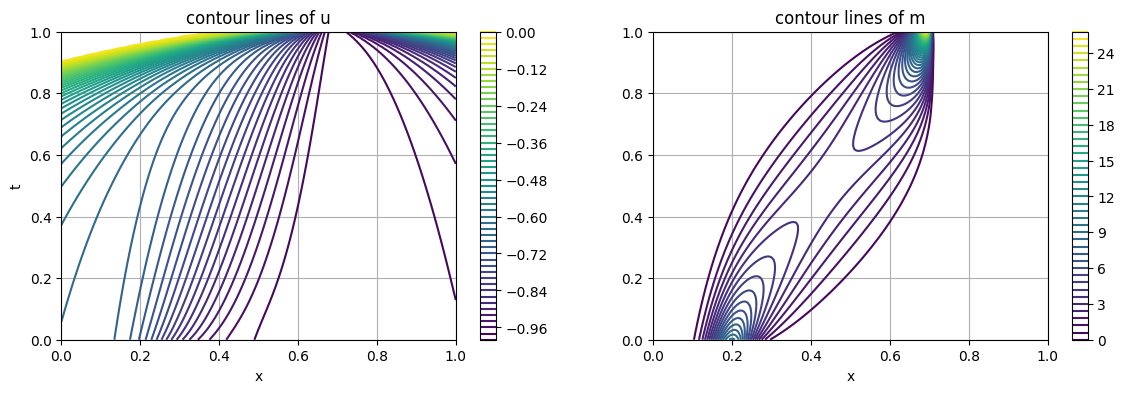

In [54]:
MF_res  = np.loadtxt("results/MF_res_F.csv", delimiter=",")
fig     = contour_plot(MF_res, T, Nt, Nh)
plt.show()

In [55]:
video = evolution_video(MF_res, T, Nt, Nh)
HTML(video.to_jshtml())

## <span style="color:#00B8DE">III - Mean Field Control Results </span>

In [56]:
'''
Path("results").mkdir(parents=True, exist_ok=True)
Path("statistics").mkdir(parents=True, exist_ok=True)
set_                = 'G'
# Here, we set theta = 0.009 and crit_fixpoint = 2*10**(-3) due to convergence difficulties.
theta               = 0.009
crit_fixpoint       = 2*10**(-3)
MF_res, MF_stats    = MF_solver(sets_params['sigma'][set_], sets_params['beta'][set_], sets_params['c0'][set_], sets_params['c1'][set_], sets_params['alpha'][set_], T, Nt, Nh, theta, sets_params['f0tilde'][set_], sets_params['f0tilde_p'][set_], crit_fixpoint, crit_newt, SPARSE, False, True, sets_params['type'][set_])
video               = evolution_video(MF_res, T, Nt, Nh)
fig                 = contour_plot(MF_res, T, Nt, Nh)
np.savetxt(f"results/MF_res_{set_}.csv", MF_res, delimiter=",")
video.save(f"results/MF_res_{set_}.mp4")
    plt.savefig(f'results/MF_res_{set_}.png', bbox_inches='tight', dpi=300)
save_stats_to_txt(MF_stats, f"statistics/MF_stats_{set_}.txt")
plt.close('all')
'''

'\nPath("results").mkdir(parents=True, exist_ok=True)\nPath("statistics").mkdir(parents=True, exist_ok=True)\nset_                = \'G\'\n# Here, we set theta = 0.009 and crit_fixpoint = 2*10**(-3) due to convergence difficulties.\ntheta               = 0.009\ncrit_fixpoint       = 2*10**(-3)\nMF_res, MF_stats    = MF_solver(sets_params[\'sigma\'][set_], sets_params[\'beta\'][set_], sets_params[\'c0\'][set_], sets_params[\'c1\'][set_], sets_params[\'alpha\'][set_], T, Nt, Nh, theta, sets_params[\'f0tilde\'][set_], sets_params[\'f0tilde_p\'][set_], crit_fixpoint, crit_newt, SPARSE, False, True, sets_params[\'type\'][set_])\nvideo               = evolution_video(MF_res, T, Nt, Nh)\nfig                 = contour_plot(MF_res, T, Nt, Nh)\nnp.savetxt(f"results/MF_res_{set_}.csv", MF_res, delimiter=",")\nvideo.save(f"results/MF_res_{set_}.mp4")\n    plt.savefig(f\'results/MF_res_{set_}.png\', bbox_inches=\'tight\', dpi=300)\nsave_stats_to_txt(MF_stats, f"statistics/MF_stats_{set_}.txt")\nplt

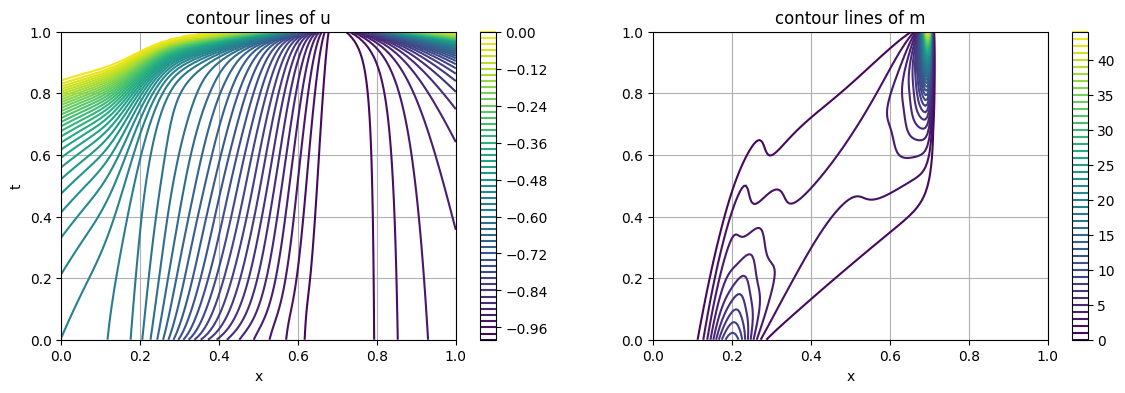

In [57]:
MF_res  = np.loadtxt("results/MF_res_G.csv", delimiter=",")
fig     = contour_plot(MF_res, T, Nt, Nh)
plt.show()

In [58]:
video = evolution_video(MF_res, T, Nt, Nh)
HTML(video.to_jshtml())

## <span style="color:#00B8DE">IV - Data Analysis of Statistics </span>

In [59]:
'''
Path("statistics").mkdir(parents=True, exist_ok=True)
set_                = 'G'
theta               = 0.009
crit_fixpoint       = -np.inf
MF_res, MF_stats    = MF_solver(sets_params['sigma'][set_], sets_params['beta'][set_], sets_params['c0'][set_], sets_params['c1'][set_], sets_params['alpha'][set_], T, Nt, Nh, theta, sets_params['f0tilde'][set_], sets_params['f0tilde_p'][set_], crit_fixpoint, crit_newt, SPARSE, False, False, sets_params['type'][set_])
save_stats_to_txt(MF_stats, f"statistics/MF_stats_{set_}_bis.txt")
set_                = 'F'
theta               = 0.02
crit_fixpoint       = -np.inf
MF_res, MF_stats    = MF_solver(sets_params['sigma'][set_], sets_params['beta'][set_], sets_params['c0'][set_], sets_params['c1'][set_], sets_params['alpha'][set_], T, Nt, Nh, theta, sets_params['f0tilde'][set_], sets_params['f0tilde_p'][set_], crit_fixpoint, crit_newt, SPARSE, False, False, sets_params['type'][set_])
save_stats_to_txt(MF_stats, f"statistics/MF_stats_{set_}_bis.txt")
'''

'\nPath("statistics").mkdir(parents=True, exist_ok=True)\nset_                = \'G\'\ntheta               = 0.009\ncrit_fixpoint       = -np.inf\nMF_res, MF_stats    = MF_solver(sets_params[\'sigma\'][set_], sets_params[\'beta\'][set_], sets_params[\'c0\'][set_], sets_params[\'c1\'][set_], sets_params[\'alpha\'][set_], T, Nt, Nh, theta, sets_params[\'f0tilde\'][set_], sets_params[\'f0tilde_p\'][set_], crit_fixpoint, crit_newt, SPARSE, False, False, sets_params[\'type\'][set_])\nsave_stats_to_txt(MF_stats, f"statistics/MF_stats_{set_}_bis.txt")\nset_                = \'F\'\ntheta               = 0.02\ncrit_fixpoint       = -np.inf\nMF_res, MF_stats    = MF_solver(sets_params[\'sigma\'][set_], sets_params[\'beta\'][set_], sets_params[\'c0\'][set_], sets_params[\'c1\'][set_], sets_params[\'alpha\'][set_], T, Nt, Nh, theta, sets_params[\'f0tilde\'][set_], sets_params[\'f0tilde_p\'][set_], crit_fixpoint, crit_newt, SPARSE, False, False, sets_params[\'type\'][set_])\nsave_stats_to_txt(MF_st

In [60]:
MF_stats_G = load_stats_from_txt(f"statistics/MF_stats_G_bis.txt")
MF_stats_F = load_stats_from_txt(f"statistics/MF_stats_F.txt")

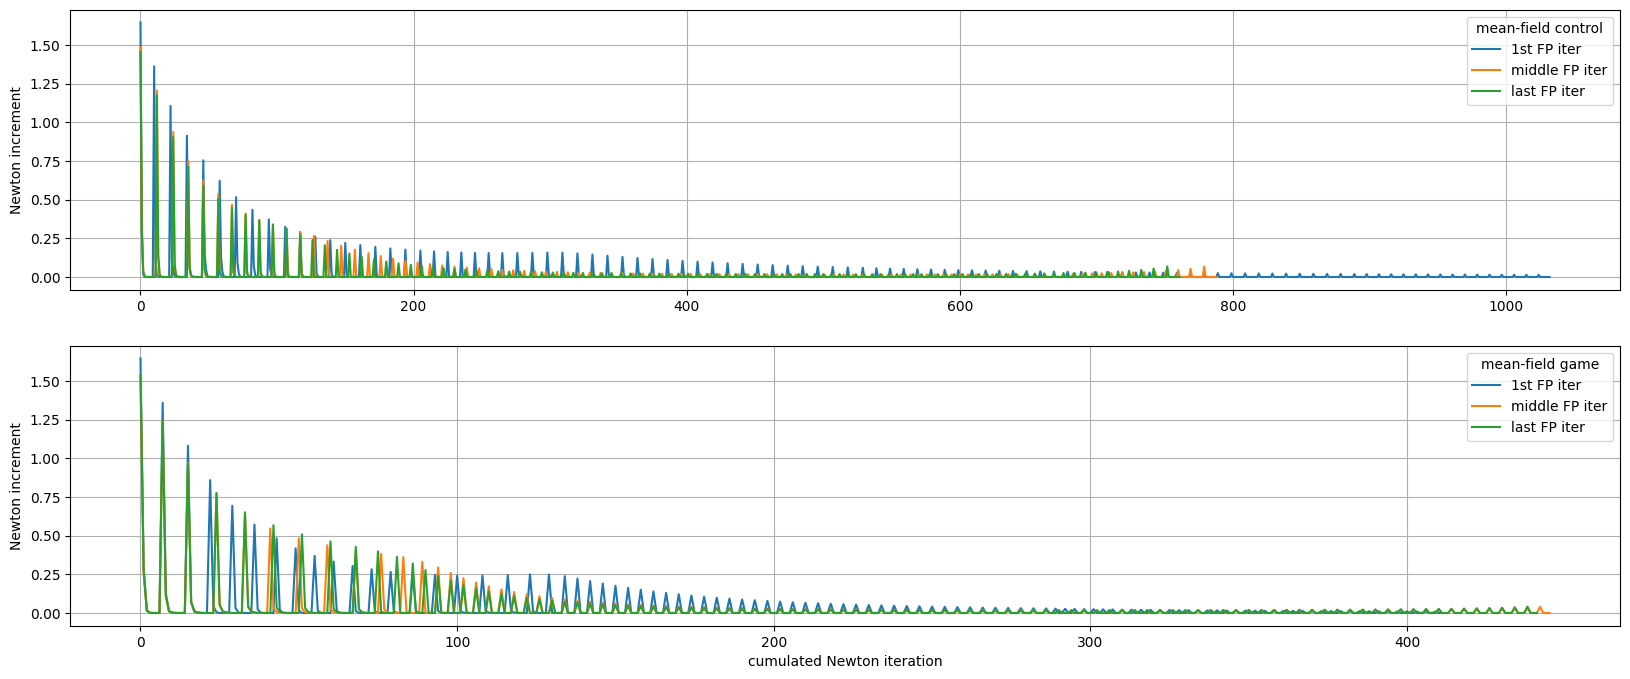

In [61]:
fig, axs        = plt.subplots(2, 1, figsize=(20, 8))
niters_fp_G     = len(MF_stats_G['fixpoint_increments'])
niters_fp_F     = len(MF_stats_F['fixpoint_increments'])
axs[0].grid()
axs[0].plot(MF_stats_G['newton_increments'][0], label='1st FP iter')
axs[0].plot(MF_stats_G['newton_increments'][(niters_fp_G-1)//2], label='middle FP iter')
axs[0].plot(MF_stats_G['newton_increments'][niters_fp_G-1], label='last FP iter')
axs[0].set_ylabel('Newton increment')
axs[0].legend(title="mean-field control")
axs[1].grid()
axs[1].plot(MF_stats_F['newton_increments'][0], label='1st FP iter')
axs[1].plot(MF_stats_F['newton_increments'][(niters_fp_F-1)//2], label='middle FP iter')
axs[1].plot(MF_stats_F['newton_increments'][niters_fp_F-1], label='last FP iter')
axs[1].set_xlabel('cumulated Newton iteration')
axs[1].set_ylabel('Newton increment')
axs[1].legend(title="mean-field game")
plt.show()

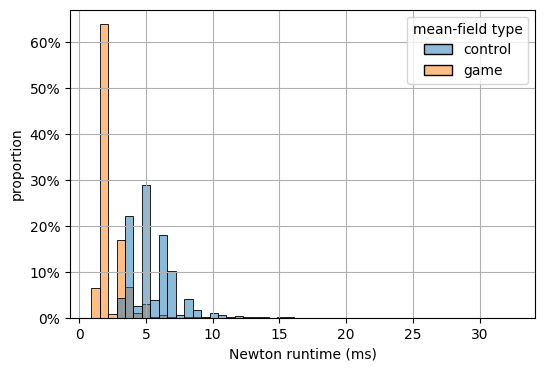

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
res_G   = np.concatenate(MF_stats_G['newton_times'])
res_F   = np.concatenate(MF_stats_F['newton_times'])
df      = pd.DataFrame({'newton_times': np.concatenate((res_G, res_F))*10**3, 'mean-field type': ['control']*len(res_G) + ['game']*len(res_F)})
sns.histplot(df, x='newton_times', bins=50, stat='proportion', ax=ax, hue='mean-field type', common_norm=False)
ax.grid()
ax.set_xlabel('Newton runtime (ms)')
ax.set_ylabel('proportion')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
#plt.savefig(f'statistics/newton_runtime.png', bbox_inches='tight', dpi=300)
plt.show()

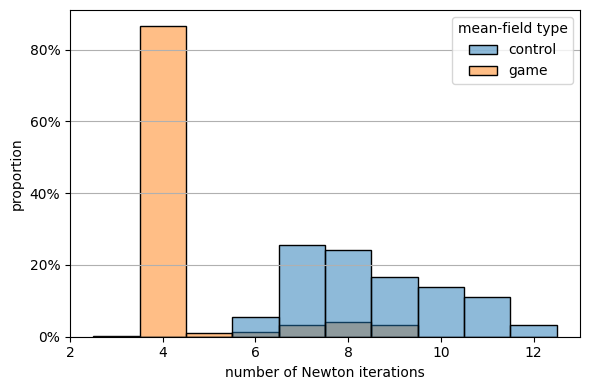

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
res_G   = np.concatenate(MF_stats_G['newton_niters'])
res_F   = np.concatenate(MF_stats_F['newton_niters'])
df      = pd.DataFrame({'newton_niters': np.concatenate((res_G, res_F)), 'mean-field type': ['control']*len(res_G) + ['game']*len(res_F)})
sns.histplot(df, x='newton_niters', kde=False, bins=len(np.unique(res_G)), ax=ax, color='skyblue', stat='probability', discrete=True, hue='mean-field type', common_norm=False)
ax.set_xlabel('number of Newton iterations')
ax.set_ylabel('proportion')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax.grid(axis='y')
plt.tight_layout()
#plt.savefig(f'statistics/newton_iters.png', bbox_inches='tight', dpi=300)
plt.show()

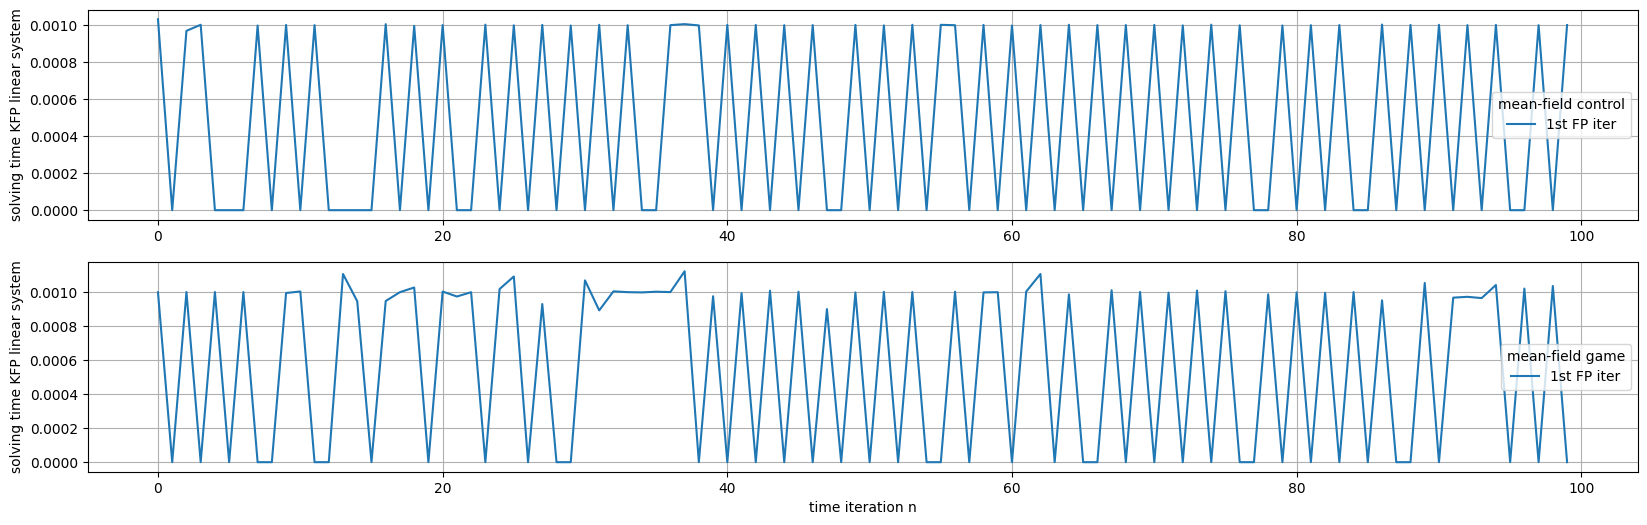

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
axs[0].grid()
axs[0].plot(MF_stats_G['system_times'][0], label='1st FP iter')
#axs[0].plot(MF_stats_G['system_times'][-1], label='last FP iter')
axs[0].set_ylabel('solving time KFP linear system')
axs[0].legend(title="mean-field control")
axs[1].grid()
axs[1].plot(MF_stats_F['system_times'][0], label='1st FP iter')
axs[1].set_ylabel('solving time KFP linear system')
axs[1].legend(title="mean-field game")
axs[1].set_xlabel('time iteration n')
plt.show()

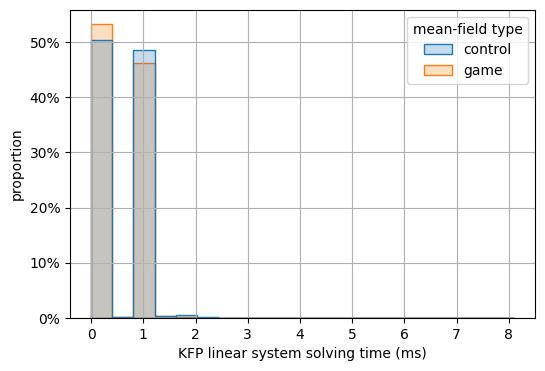

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
res_G   = np.concatenate(MF_stats_G['system_times'])
res_F   = np.concatenate(MF_stats_F['system_times'])
df      = pd.DataFrame({'system_times': np.concatenate((res_G, res_F))*10**3, 'mean-field type': ['control']*len(res_G) + ['game']*len(res_F)})
sns.histplot(df, x='system_times', bins=20, stat='proportion', ax=ax, hue='mean-field type', common_norm=False, element='step')
ax.grid()
ax.set_xlabel('KFP linear system solving time (ms)')
ax.set_ylabel('proportion')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
#plt.savefig(f'statistics/linearsys_runtime.png', bbox_inches='tight', dpi=300)
plt.show()

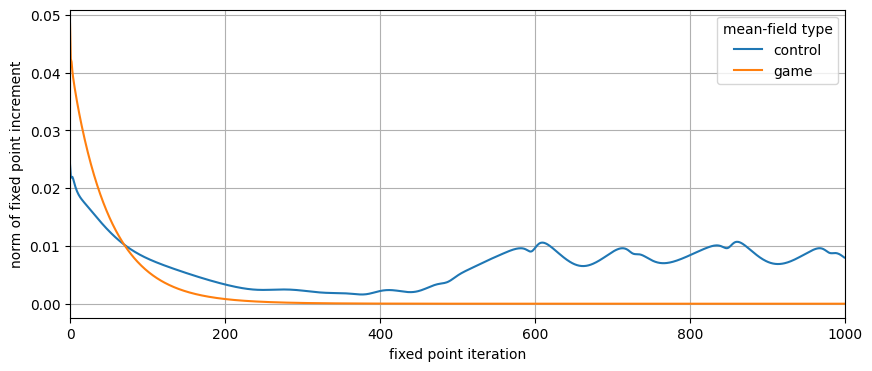

In [66]:
MF_stats_F_bis  = load_stats_from_txt(f"statistics/MF_stats_F_bis.txt")
fig, ax         = plt.subplots(1, 1, figsize=(10, 4))
ax.grid()
sns.lineplot(MF_stats_G['fixpoint_increments'], label='control', ax=ax)
sns.lineplot(MF_stats_F_bis['fixpoint_increments'], label='game', ax=ax)
ax.set_xlabel('fixed point iteration')
ax.set_xlim(0, 1000)
ax.set_ylabel('norm of fixed point increment')
ax.legend(title='mean-field type')
#plt.savefig(f'statistics/convergence_issues.png', bbox_inches='tight', dpi=300)
plt.show()

Total Running time for set A: 146.32 s
Total Running time for set B: 105.03 s
Total Running time for set C: 148.21 s
Total Running time for set D: 127.55 s
Total Running time for set E: 106.59 s


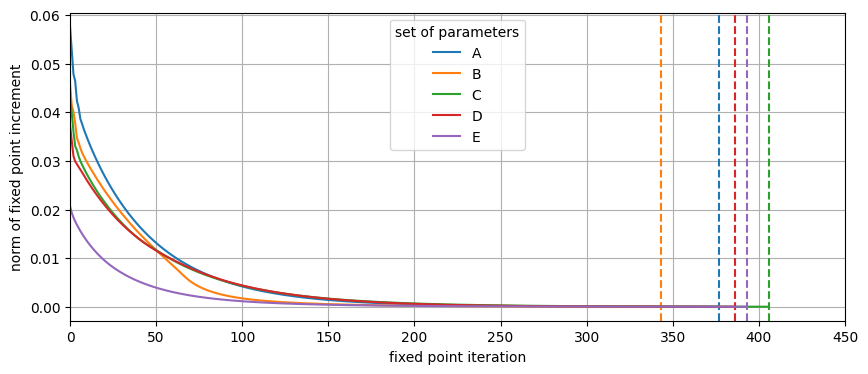

In [67]:
fig, ax         = plt.subplots(1, 1, figsize=(10, 4))
ax.grid()
sets_ = ['A', 'B', 'C', 'D', 'E']
colors = sns.color_palette('tab10', len(sets_))
for i, s in enumerate(sets_):
    MF_stats = load_stats_from_txt(f"statistics/MF_stats_{s}.txt")
    sns.lineplot(MF_stats['fixpoint_increments'], label=s, ax=ax, color=colors[i])
    ax.axvline(x=len(MF_stats['fixpoint_increments']), linestyle='--', color=colors[i])
    print(f"Total Running time for set {s}: {MF_stats['runtime']:.2f} s")
ax.set_xlabel('fixed point iteration')
ax.set_xlim(0, 450)
ax.set_ylabel('norm of fixed point increment')
ax.legend(title='set of parameters')
#plt.savefig(f'statistics/convergence.png', bbox_inches='tight', dpi=300)
plt.show()